# scRNA-seq analysis for CellOracle using ScanPy
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook preprocesses the scRNA-seq data that will be used for a CellOracle analysis.

# Set-up

In [2]:
# Global Imports
import os
import sys
import yaml
import datetime
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive

import scanpy as sc
import scanpy.external as sce
sc.settings.verbosity = 3
random_state = 13

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

In [3]:
# Notebook and figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

In [ ]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"

# Inputs
platinum_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/platinum"
in_date = "25Aug23"
in_dir = os.path.join(platinum_dir, dataset_name, in_date, "scRNA")

# Outputs
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results"
analysis = "scRNAseq_data_preparation"
#out_date = datetime.datetime.now().strftime("%d%b%y").lower()
out_date = "27Aug23"
out_dir = os.path.join(results_dir, dataset_name, out_date, analysis)
make_dirs(out_dir)

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results/igvf_sc-islet_10X-Multiome/27aug23/scRNAseq_data_preparation'

In [7]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_date": out_date,
    "out_dir": out_dir,
    "random_state": random_state,
}
version_params = {
    "Python": sys.version[:5],
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "scanpy": sc.__version__,
    "seaborn": sns.__version__,
}
params = {"data": data_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "scRNAseq_data_preparation_params.yaml")):
    with open(os.path.join(out_dir, "scRNAseq_data_preparation_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [8]:
# The data to load in formatted as a 10x directory, change if you have a different format for reading in data
adata = sc.read_10x_mtx(in_dir, cache=True)

... reading from cache file cache/cellar-users-aklie-data-igvf-beta_cell_networks-platinum-igvf_sc-islet_10X-Multiome-25Aug23-scRNA-matrix.h5ad


In [117]:
# Metadata to add, may or may not be necessary depending on the data
metadata = pd.read_csv(os.path.join(in_dir, "metadata.csv"), index_col=0)

/tmp/ipykernel_200608/2491638102.py:2: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(os.path.join(in_dir, "metadata.csv"), index_col=0)


In [118]:
# Add metadata to adata
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

# Add other useful info

In [119]:
# Print all the files in the directory
reduce_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/barcode_metadata/igvf_sc-islet_10X-Multiome/10Aug23/reductions"
print(os.listdir(reduce_dir))

['sct.harmony.tsv', 'lsi.tsv', 'harmony.tsv', 'pca.tsv', 'atac.harmony.tsv', 'umap.wnn.tsv']


In [120]:
# We are going to add some dim reductions from a Seurat object to this adata object
umap_wnn = pd.read_csv(os.path.join(reduce_dir, "umap.wnn.tsv"), index_col=0, sep="\t")
sct_harmony = pd.read_csv(os.path.join(reduce_dir, "sct.harmony.tsv"), index_col=0, sep="\t")
harmony = pd.read_csv(os.path.join(reduce_dir, "harmony.tsv"), index_col=0, sep="\t")
pca = pd.read_csv(os.path.join(reduce_dir, "pca.tsv"), index_col=0, sep="\t")
atac_harmony = pd.read_csv(os.path.join(reduce_dir, "atac.harmony.tsv"), index_col=0, sep="\t")
lsi = pd.read_csv(os.path.join(reduce_dir, "lsi.tsv"), index_col=0, sep="\t")

In [121]:
# Add the dim reductions to the adata object
adata.obsm["Seurat_umap_wnn"] = umap_wnn.values
adata.obsm["Seurat_sct_harmony"] = sct_harmony.values
adata.obsm["Seurat_harmony"] = harmony.values
adata.obsm["Seurat_pca"] = pca.values
adata.obsm["Seurat_atac_harmony"] = atac_harmony.values
adata.obsm["Seurat_lsi"] = lsi.values

In [122]:
# Add the SoupX rounded counts to the adata object
adata.obs["nCount_RNA_round"] = adata.X.sum(axis=1)
adata.obs["log_nCount_RNA_round"] = np.log(adata.obs["nCount_RNA_round"])

In [123]:
# Clean up
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("category")

# Sanity check your data

In [1]:
# Check the adata object
sc.pl.embedding(adata, basis='Seurat_umap_wnn', color=['predicted.cell.type', 'sample', 'batch'])

NameError: name 'sc' is not defined

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


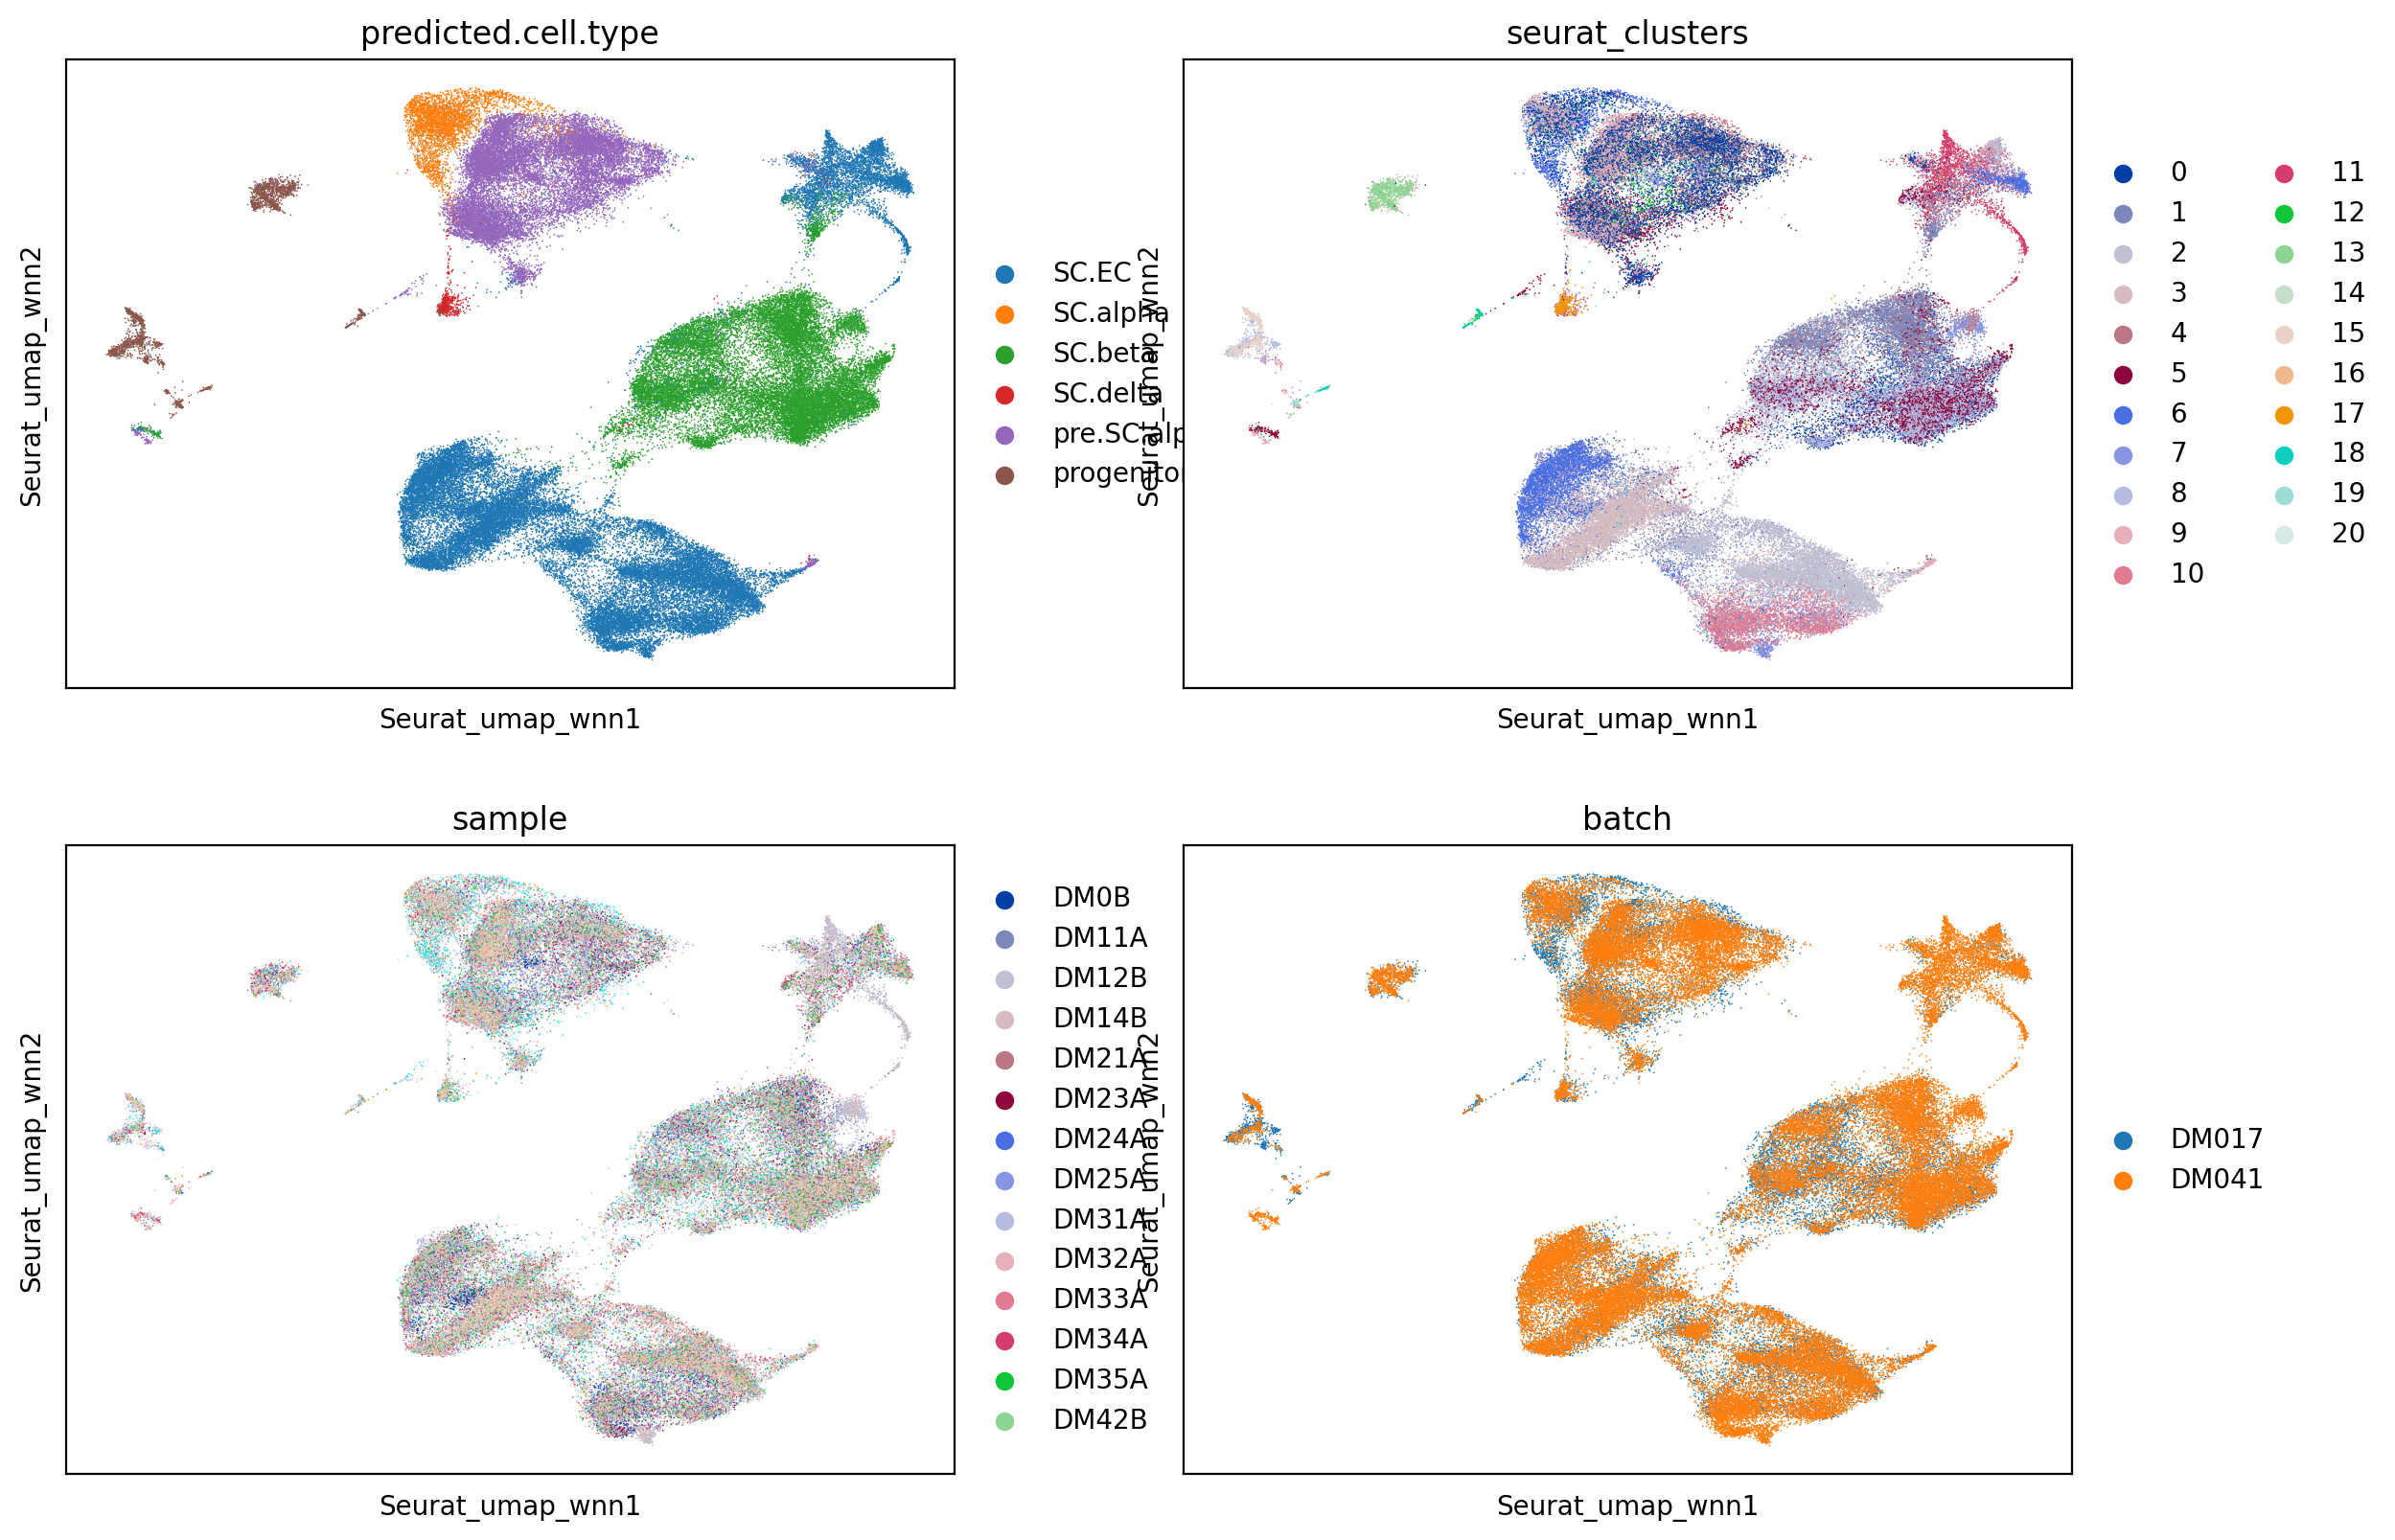

In [124]:
# Check the adata object
sc.pl.embedding(adata, basis='Seurat_umap_wnn', color=['predicted.cell.type', 'seurat_clusters', 'sample', 'batch'], ncols=2)

# Preprocessing the data

## Normalization and variable gene selection

In [125]:
# Check for counts
adata.X[:10, :10].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [126]:
# Save the raw raw counts
adata.layers["raw_counts"] = adata.X.copy()
adata.layers["raw_counts"][:10, :10].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [127]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)


In [128]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(
    adata.X,
    flavor='cell_ranger',
    n_top_genes=3000,
    log=False
)

extracting highly variable genes
    finished (0:00:02)


/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:191: RuntimeWarning: divide by zero encountered in divide
  np.abs(
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:191: RuntimeWarning: invalid value encountered in divide
  np.abs(


In [129]:
# Subset the genes
adata = adata[:, filter_result.gene_subset]

In [95]:
# Renormalize after filtering -- don't think this needs to be done and is kind of weird cuz you are normalizing something that is already normalized
#sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_hvg')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_hvg', counts per cell before normalization (adata.obs)


In [138]:
# keep raw normalized data before log transformation
adata.raw = adata

In [142]:
# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## Dim reduction
Note we don't actually have to do this here since we already have coordinates from previous analyses we should probably stick with. Because of this, I'm not doing a whole lot with the parameters here.

In [143]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:47)


/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


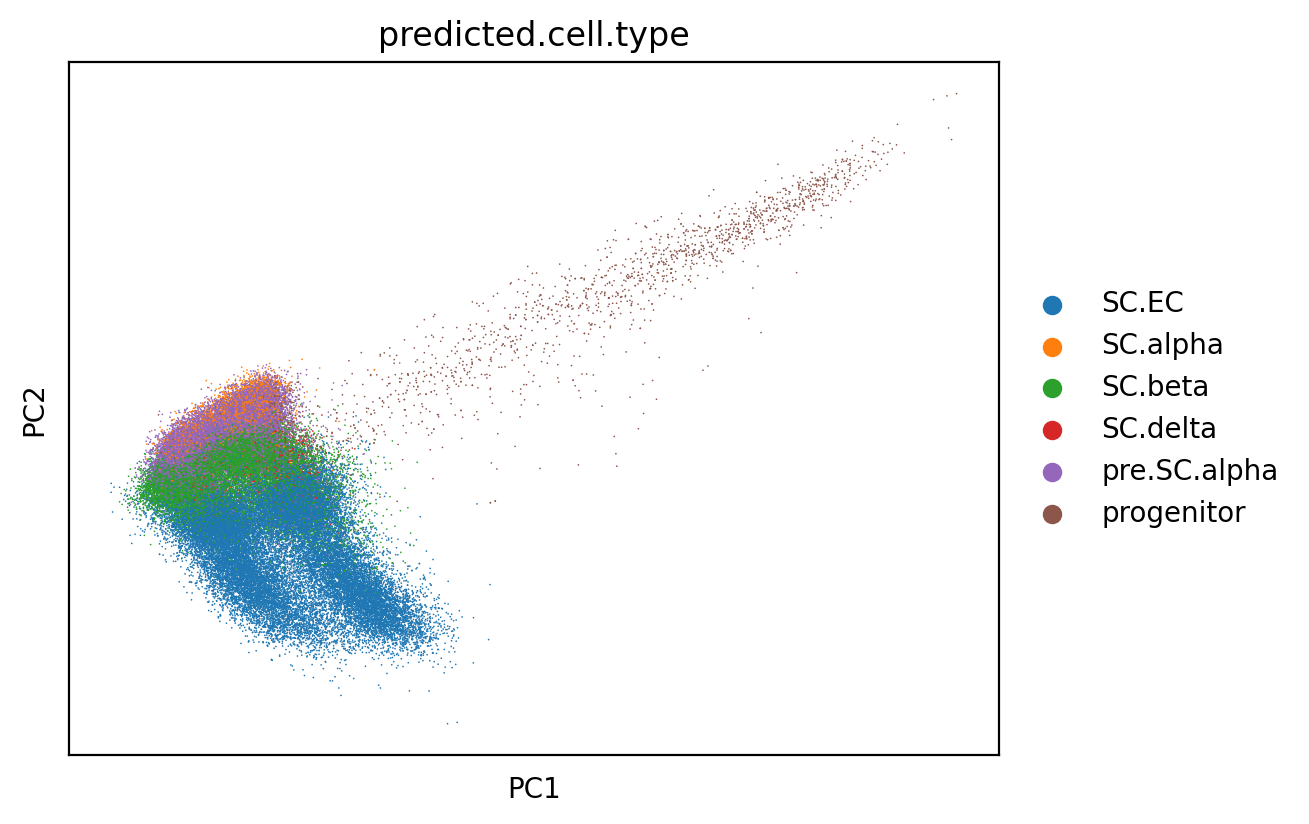

In [144]:
# Plot PCA
sc.pl.pca(adata, color="predicted.cell.type")

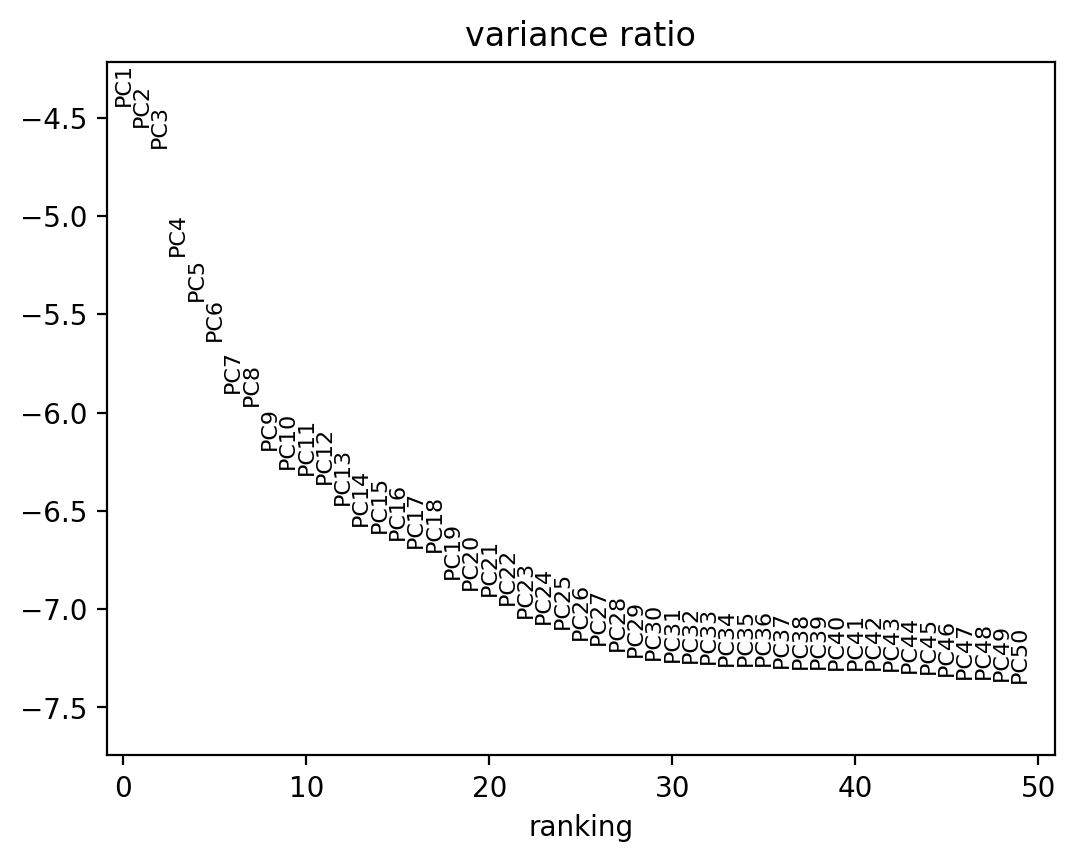

In [145]:
# See how much variance is explained by each PC
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [146]:
# find neighbors
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cellar/users/aklie/opt/miniconda3/envs/

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:50)


In [150]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:46)


In [152]:
adata

AnnData object with n_obs × n_vars = 83289 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'cell.type.1', 'cell.type.2', 'predicted.cell.type', 'predicted.cell.type.score', 'nCount_RNA_round', 'log_nCount_RNA_round', 'n_counts_all'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'predicted.cell.type_colors', 'seurat_clusters_colors', 'sample_colors', 'batch_colors', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'Seurat_umap_wnn', 'Seurat_sct_harmony', 'Seurat_harmony', 'Seurat_pca', 'Seu

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


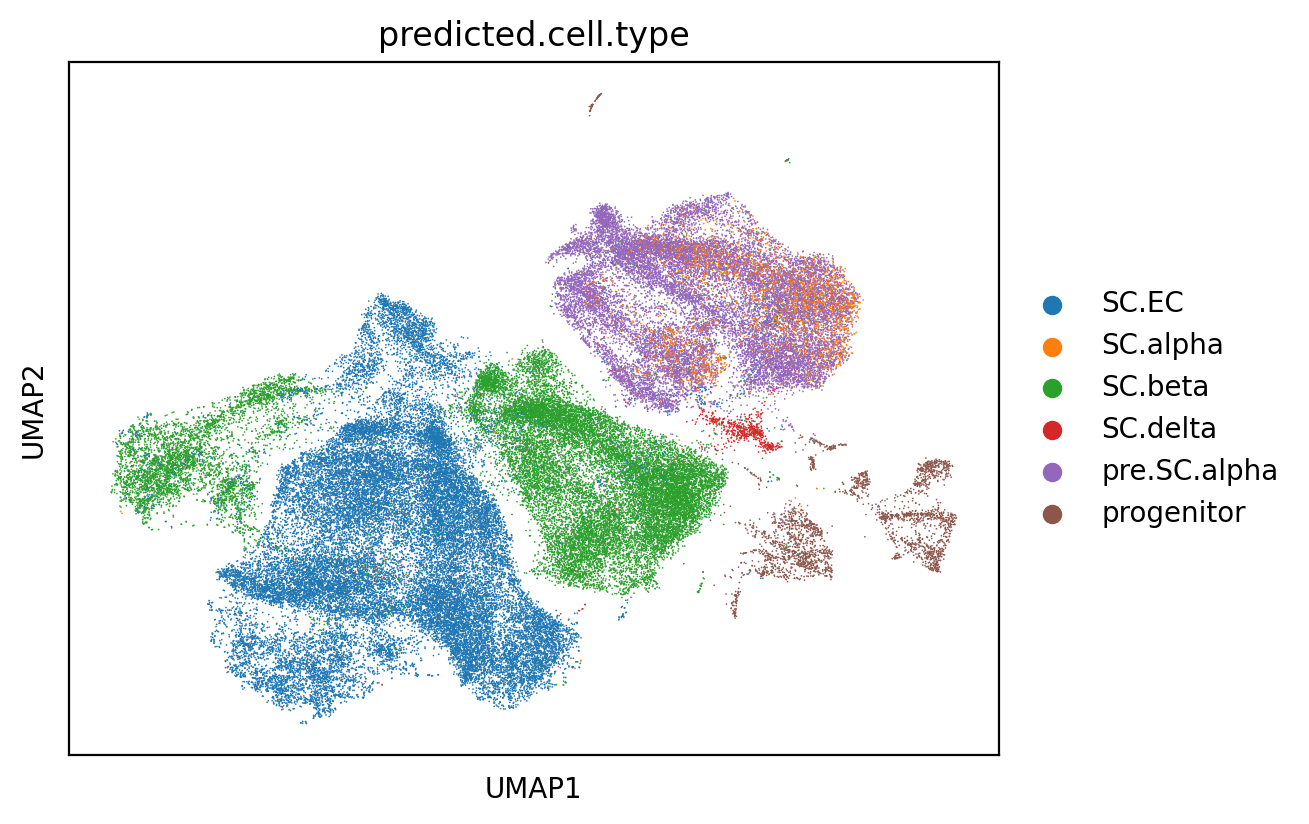

In [151]:
# Plot UMAP
sc.pl.umap(adata, color="predicted.cell.type")

# Save H5AD file

In [153]:
adata.write_h5ad(os.path.join(out_dir, "scRNA_processed.h5ad"))

# DONE!

---